# Log Gaussian

`lamatrix` provides a log Gaussian to fit to data. This model has some nuances, let's take a look.

Let's look at the equation for this model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-10, 10, 0.01)


from lamatrix import lnGaussian, Gaussian

In [2]:
lnGaussian().equation

'\\[f(\\mathbf{x}) = w_{0} x^2 + w_{1} x + w_{2} \\]'

You can see here, this looks like a simple 2nd order polynomial. Let's remind ourselves of the equatino for a Gaussian


$$
G(x) = A\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

We see that this is linear only in one of these variables: $A$. But if we look in log space
$$
\ln(G(x)) = \ln(A) -\frac{1}{2} \ln(2\pi\sigma^2) - \frac{(x - \mu)^2}{2\sigma^2}
$$
Which expands to
$$
\ln(G(x)) = \ln(A) -\frac{1}{2} \ln(2\pi\sigma^2) - \frac{x^2}{2\sigma^2} + \frac{x\mu}{\sigma^2} - \frac{\mu^2}{2\sigma^2}
$$


We see that this is now a linear model where
$$
a = - \frac{1}{2\sigma^2}
$$
$$
b = \frac{\mu}{\sigma^2}
$$
$$
c = \ln(A) -\frac{1}{2} \ln(2\pi\sigma^2) - \frac{\mu^2}{2\sigma^2}
$$
$$
\ln(G(x)) = a x^2 + b x + c
$$

This is our simple 2nd order polynomial. But you see here, there are some constraints on the weights $a$, $b$ and $c$ which relate to the properties of the Gaussian $\mu$, $\sigma$ and $A$.

In our framework we are able to put Gaussian priors our coefficients. We specify them with `(mean, standard deviation)` (see the tutorial on setting priors). We could set priors on $a$, $b$ and $c$, which would constraint $\mu$, $\sigma$ and $A$. Similarly, we could specify priors in $\mu$, $\sigma$ and $A$, and then calculate the effective priors on $a$, $b$ and $c$. This is what the `lnGaussian` model enables you to do. However there is a nuance; priors that are Gaussian on $a$, $b$ and $c$ are not Gaussian on $\mu$, $\sigma$ and $A$. And priors on $\mu$, $\sigma$ and $A$ are not Gaussian on $a$, $b$ and $c$. Let's see an example below

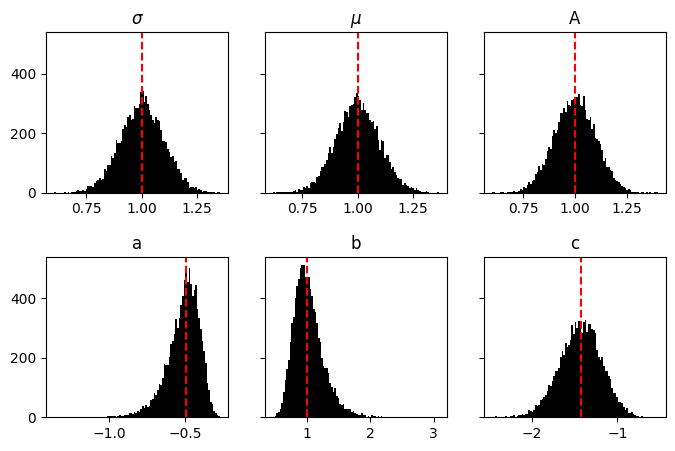

In [3]:
# Generate normal distributed sigma, mu, and A
sigma, mu, A = np.random.normal(1, 0.1, size=(10000, 3)).T

# Calculate a, b, c
a = lambda sigma, mu, A: -(1/(2*sigma**2))
b = lambda sigma, mu, A: mu/sigma**2
c = lambda sigma, mu, A: np.log(A) - 0.5*np.log(2*np.pi*sigma**2) - (mu**2/2*sigma**2)

# Plot as histographs
fig, ax = plt.subplots(2, 3, figsize=(8, 5), sharey=True)
[a.hist(var, 100, color='black') for a, var in zip(ax.ravel(), [sigma, mu, A, a(sigma, mu, A), b(sigma, mu, A), c(sigma, mu, A)])]
[a.set(title=label) for a, label in zip(ax.ravel(), ['$\sigma$', '$\mu$', 'A', 'a', 'b', 'c'])];

[a.axvline(np.nanmedian(var), ls='--', c='r') for a, var in zip(ax[0], [sigma, mu, A])]
[a.axvline(np.nanmedian(var), ls='--', c='r') for a, var in zip(ax[1], [a(sigma, mu, A), b(sigma, mu, A), c(sigma, mu, A)])]

plt.subplots_adjust(hspace=0.4)

Here we see that normal distributed $\mu$, $\sigma$ and $A$ result in non-normal distributed $a$, $b$ and $c$.

This is important to remember. In our framework of linear algebra, we are only able to put normal priors on any value. Therefore, inside `lnGaussian`, we are implicitly approximating all of these distributions as normal. 

Let's see this in practice

In [4]:
model = lnGaussian(prior_sigma=(3, 0.1), prior_mu=(2, 0.1), prior_A=(10, 1))

Here I've created a `lnGaussian` model with priors on $\mu$, $\sigma$ and $A$. This has then generated priors on the three coefficients $a$, $b$ and $c$

In [5]:
model.priors

DistributionContainer
	[(-0.0556, 0.0037), (0.222, 0.019), (0.06, 0.11)]

These will be treated as normal distributions, even though we know this is an approximation. Let's create some models using these priors

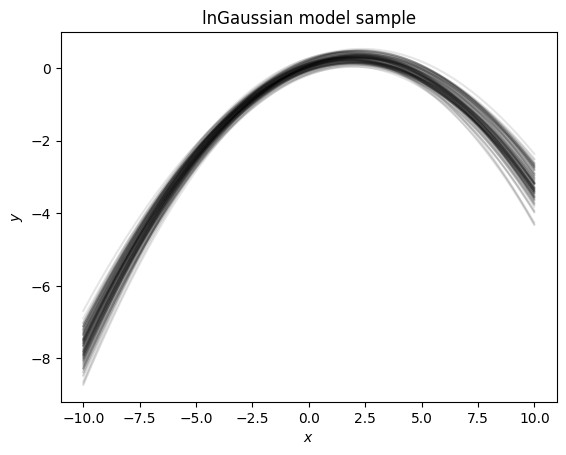

In [6]:
fig, ax = plt.subplots()
[ax.plot(x, model(x=x).dot(model.priors.sample()), c='k', alpha=0.1) for count in range(100)];
ax.set(xlabel='$x$', ylabel='$y$', title='lnGaussian model sample');

We see here that the draws from these priors create a similar trend, not a random 2nd order polynomial. Let's look at this in linear space instead of log space

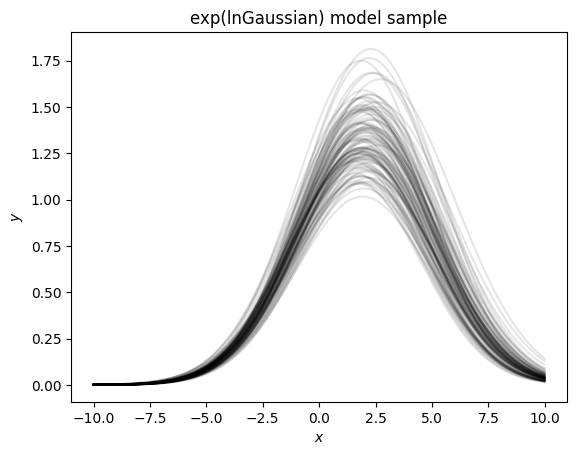

In [7]:
fig, ax = plt.subplots()
[ax.plot(x, np.exp(model(x=x).dot(model.priors.sample())), c='k', alpha=0.1) for count in range(100)];
ax.set(xlabel='$x$', ylabel='$y$', title='exp(lnGaussian) model sample');

Now that we take the exponent we see this has drawn many Gaussians with properties similar to our input priors. However if we take 5000 draws and plot them we see that there is a bias in our sampling

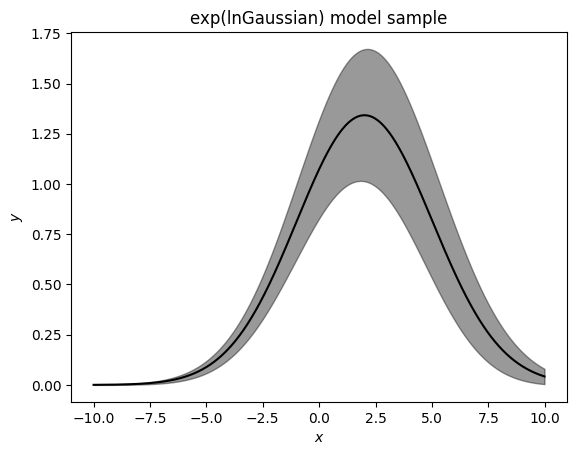

In [8]:
ar = np.asarray([np.exp(model(x=x).dot(model.priors.sample())) for count in range(5000)])

fig, ax = plt.subplots()
ax.plot(x, ar.mean(axis=0), c='k')
ax.fill_between(x, ar.mean(axis=0) - 2*ar.std(axis=0), ar.mean(axis=0) + 2*ar.std(axis=0), color='k', alpha=0.4) 
ax.set(xlabel='$x$', ylabel='$y$', title='exp(lnGaussian) model sample');

Here we see we are slightly biased towards drawing lower values of $\mu$. When using this model it is important to recognize that this is not a model that is unbiased in linear space.

With those understandings, let's fit some data. We'll generate some fake data using the `Gaussian` model object.

In [9]:
A, mu, sigma = 10, -0.5, 1
truth = Gaussian('x', sigma=sigma, mu=mu)(x=x).dot([A]) 
data = truth + np.random.normal(0, 0.01, size=x.shape[0])
errors = np.ones_like(x) * 0.01

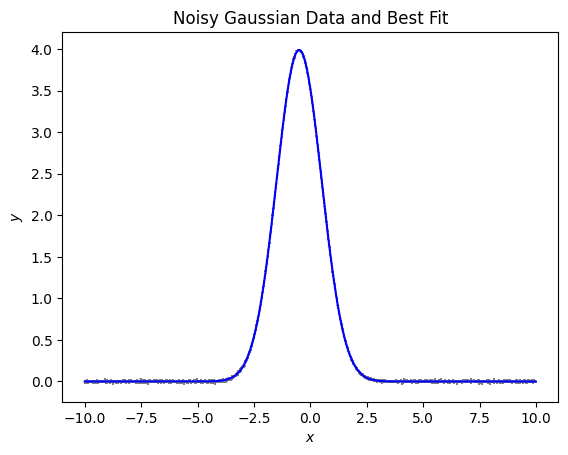

In [10]:
fig, ax = plt.subplots()
ax.errorbar(x, data, errors, ls='', c='grey')
ax.plot(x, truth, c='blue')
ax.set(xlabel='$x$', ylabel='$y$', title='Noisy Gaussian Data and Best Fit');

When we look at the plotted data this looks good. To fit this we will have to fit in log space, let's look at the data in log space. To use log space we will have to look at only data that is positive. We wi ll have to remove any data that goes below 0 due to noise. We will remove any points that are less than zero.

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_22770/3557338474.py:3: RuntimeWarning: invalid value encountered in log
  ax.errorbar(x[k], np.log(data[k]), np.abs(errors/data)[k], ls='', c='grey', lw=1, label='data')


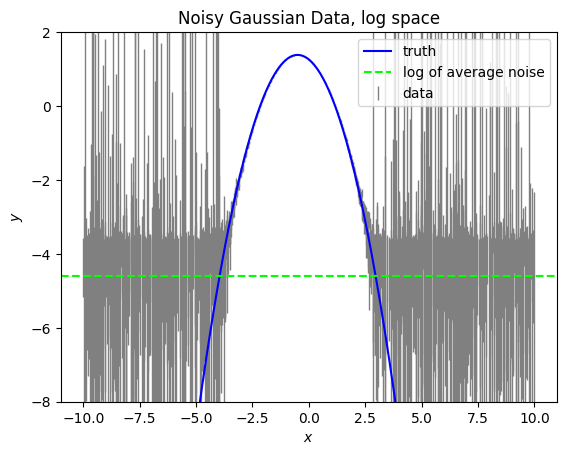

In [11]:
fig, ax = plt.subplots()
k = truth > 0
ax.errorbar(x[k], np.log(data[k]), np.abs(errors/data)[k], ls='', c='grey', lw=1, label='data')
ax.plot(x, np.log(truth), c='blue', label='truth')
ax.axhline(np.log(0.01), c='lime', ls='--', label='log of average noise')
ax.legend()
ax.set(ylim=(-8, 2), xlabel='$x$', ylabel='$y$', title='Noisy Gaussian Data, log space');

Here we see that the noise causes a "floor". Anywhere where the data is close to this noise floor will impact our fit. In the case that there is a lot of noise in the wings, you may need to remove this to ensure a good fit.

In [12]:
model = lnGaussian('x')
k = data > 0
model.fit(x=x[k], data=np.log(data[k]), errors=errors[k]/data[k])

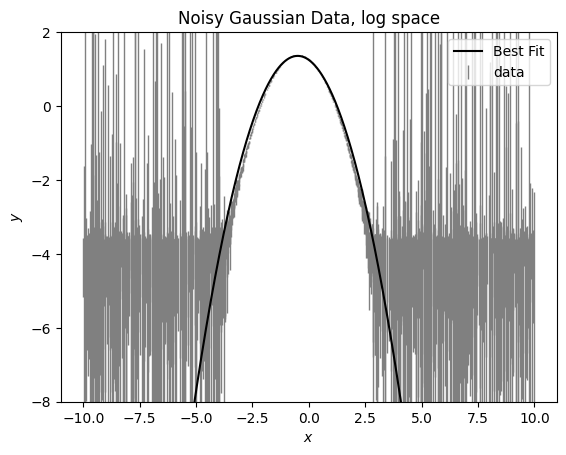

In [13]:
fig, ax = plt.subplots()
k = data > 0
ax.errorbar(x[k], np.log(data[k]), np.abs(errors/data)[k], ls='', c='grey', lw=1, label='data')
ax.plot(x, model.evaluate(x=x), c='k', label='Best Fit')
ax.legend()
ax.set(ylim=(-8, 2), xlabel='$x$', ylabel='$y$', title='Noisy Gaussian Data, log space');

We see here that the model doesn't fit well at the wings. This is because the noise is more significant of a contribution in the wings and it's impacting our fit. We can remove those wings by removing any data that is within 3x the error of zero.

In [14]:
model = lnGaussian('x')
k = data > 3*errors
model.fit(x=x[k], data=np.log(data[k]), errors=errors[k]/data[k])

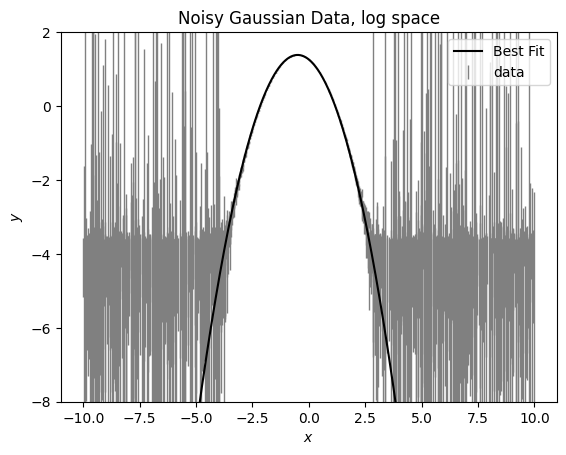

In [15]:
fig, ax = plt.subplots()
k = data > 0
ax.errorbar(x[k], np.log(data[k]), np.abs(errors/data)[k], ls='', c='grey', lw=1, label='data')
ax.plot(x, model.evaluate(x=x), c='k', label='Best Fit')
ax.legend()
ax.set(ylim=(-8, 2), xlabel='$x$', ylabel='$y$', title='Noisy Gaussian Data, log space');

Let's look in linear space

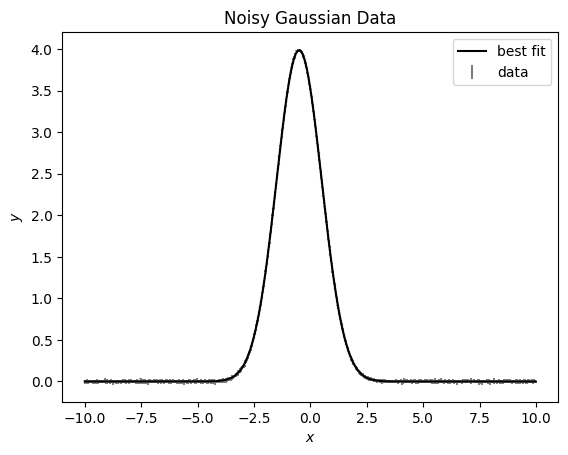

In [16]:
fig, ax = plt.subplots()
ax.errorbar(x, data, errors, ls='', c='grey', label='data')
ax.plot(x, np.exp(model.evaluate(x=x)), c='k', label='best fit')
ax.set(xlabel='$x$', ylabel='$y$', title='Noisy Gaussian Data');
ax.legend()

We can take a look at the results of our fit by looking at the posteriors

In [17]:
model.posteriors

DistributionContainer
	[(-0.49863, 0.00027), (-0.49828, 0.00038), (1.25817, 0.00024)]

These are the posteriors on our coefficients. We can convert these to posteriors on the Gaussian parameters, under the assumption that the distributions are all normal (which we tolerate is an approximation)

In [18]:
A, mu, sigma = model.coefficients_to_gaussian_parameters(model.posteriors)

In [19]:
A, mu, sigma

((10.0038, 0.0047), (-0.49965, 0.00046), (1.00137, 0.00027))

Here we see these are the same as our inputs! We note that the reported errors are an approximation, and may be an underestimate.

This model is a special case of a 2nd order polynomial to enable estimates of Gaussian parameters when using data in log space. It should be used with full understanding of the caveats discussed here, but can be powerful to fit Gaussian data.